Keong Jo Hsi 1001685  
Homework 6 (Coding) : Generating Star Trek Dialogues

Required files which are not included:
- `star_trek_transcripts_all_episodes_f.csv`

Preparing the data
-----------

In [1]:
%matplotlib inline

In [14]:
# reading the csv
category_lines = {'st' : []}
filterwords = ['NEXTEPISODE']
with open('./star_trek_transcripts_all_episodes_f.csv','r') as f:
    for line in f:
        v=line.strip().replace('=','').replace('/',' ').replace('+',' ').replace('(',' ') \
        .replace('[',' ').replace(')',' ').replace(']',' ').replace(', ','&').replace(',','^').replace('&',', ').split('^')
        for w in v:
            if (w not in filterwords) and (len(w)>1):
                category_lines['st'].append(w)


In [3]:
# obtain characters
import string
all_letters = string.ascii_letters + string.digits + " '.,:?!\n"
n_letters = len(all_letters)

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

def IndexToLetter(index):
    return all_letters[index]
    
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def IndexToTensor(index):
    tensor = torch.zeros(1, n_letters)
    tensor[0][index] = 1
    return tensor

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line,dtype):
    tensor = torch.zeros(len(line), n_letters, dtype=dtype)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor


In [5]:
import random
def partition(data, ratio=0.3):
    shuffled = random.sample(data, k=len(data))
    split_idx = int(len(shuffled)*0.3)
    return shuffled[:split_idx], shuffled[split_idx:]

In [6]:
from torch.utils.data import Dataset, DataLoader

class WordDataset(Dataset):
    def __init__(self, train_test_idx): # test=0, train=1
        self.train_test_idx = train_test_idx
        self.char_label_list = partition(category_lines['st'])[self.train_test_idx]
        
    def __getitem__(self, index):
        line = self.char_label_list[index] + '\n'
        label = torch.tensor([letterToIndex(letter) for letter in line[1:]], dtype=torch.long)
        word = lineToTensor(line[:-1], dtype=torch.float)
        return word, label # tuple of two tensors
        
    def __len__(self):
        return len(self.char_label_list)

In [7]:
def collate(batch):
    # batch = [(tensor, label), (tensor, label),...]
    # sort batch in descending order of tensor sequence length
#     print(batch)
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0], reverse=True)
    
    # sends each (tensor, label) in sorted batch into zip
    tensor, label = zip(*sorted_batch)
    
    return torch.nn.utils.rnn.pack_sequence(tensor), torch.nn.utils.rnn.pack_sequence(label)

Creating the Network
---------





In [8]:
device = torch.device('cuda:0')

In [9]:
import torch.nn as nn

class LSTMmodel(nn.Module):    
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_chars, device):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  )
        self.fc = torch.nn.Linear(hidden_size, num_chars)
        
    def forward(self, x):
#         print('x', x.data.dtype)
        # x is PackedSequence
        h_0 = torch.zeros((self.num_layers, x.batch_sizes[0], self.hidden_size), device=self.device)
        c_0 = torch.zeros((self.num_layers, x.batch_sizes[0], self.hidden_size), device=self.device)
        
#         print('h0', h_0.dtype)
#         print('c0', c_0.dtype)
        
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        # output = torch.nn.utils.rnn.PackedSequence of shape (seq_len, batch, num_directions * hidden_size)
        output = self.dropout(output.data)
        output = self.fc(output)
        return output
    
    def sample(self, char, temp):
        letter_indices = []
        char_idx = letterToIndex(char)
        
        h_n = torch.zeros((self.num_layers, 1, self.hidden_size), device=self.device)
        c_n = torch.zeros((self.num_layers, 1, self.hidden_size), device=self.device)
        
        while(char_idx != 69):
            letter_indices.append(char_idx)
            char_tensor = torch.nn.utils.rnn.pack_sequence((IndexToTensor(char_idx).to(self.device),))
                        
            # forward pass
            output, (h_n, c_n) = self.lstm(char_tensor, (h_n, c_n))
            output = self.fc(output.data)   
            
            output = output / temp
            output = torch.nn.functional.softmax(output, dim=1)
            output = torch.multinomial(output, 1) # (1 x 1)
            char_idx = output.item()
            
        chars = [IndexToLetter(i) for i in letter_indices]
        line = ''.join(chars)
        return line
            

Training
--------




In [10]:
import copy
def train(model, train_dataloader, test_dataloader, train_data_len, device=device):
    model = model.to(device)
    cross_entropy = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    total_iter = len(train_dataloader) 
    stats = []
    saved_epoch = 0
    samples = {}
    
    for epoch in range(1, 21):
        running_loss = 0
        totals = 0
        iteration = 0
        model.train()
                
        for packedseq, label in train_dataloader:
            if device.type == 'cuda':
                packedseq = packedseq.cuda()
                label = label.cuda()
            elif device.type == "cpu":
                packedseq = packedseq.cpu()
                label = label.cpu()
            
            iteration += 1
            
            optimizer.zero_grad()
            output = model(packedseq)
            
#             print('output', output, output.shape)
#             print('label', label, label.data.shape)
            
            loss = cross_entropy(output, label.data)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * label.data.shape[0]
            
            totals += label.data.shape[0]
            
            print('iter: {}/{}, running loss = {:.4f}'.format(iteration, total_iter, running_loss), end='\r')
            
        training_loss = running_loss / totals
        test_loss, test_acc = test(model, test_dataloader, device=device)
        stats.append((training_loss, test_loss, test_acc))
                   
        if test_acc > best_acc:
            best_acc = test_acc
            saved_epoch = epoch
            best_model_weights = copy.deepcopy(model.state_dict())
            
        
        torch.save(model.state_dict(),'./model_epoch{}.pt'.format(epoch))
            
        print('Epoch: {} \tTraining Loss: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f} \n'.format(
               epoch, training_loss, test_loss, test_acc))
        
        with torch.no_grad():
            uppercase_letters = string.ascii_uppercase
            samples_per_epoch = []
            
            for l in uppercase_letters:
                samples_per_epoch.append(model.sample(l, 0.5))
            samples[epoch] = samples_per_epoch
            
            for sample in samples_per_epoch:
                print(sample)
        print()
            
    print('Best Test Acc: {:4f}'.format(best_acc))
#     model.load_state_dict(best_model_weights)
    
    return stats, saved_epoch, samples

In [11]:
def test(model, dataloader, device=device):
    cross_entropy = nn.CrossEntropyLoss()
    model = model.to(device)
    model.eval()
    
    total_loss = 0
    total_corrects = 0
    count = 0
  
    with torch.no_grad():
        for packedseq, label in train_dataloader:
            if device.type == 'cuda':
                packedseq = packedseq.cuda()
                label = label.cuda()
            elif device.type == "cpu":
                packedseq = packedseq.cpu()
                label = label.cpu()
            
            output = model(packedseq)
            
            loss = cross_entropy(output, label.data)
            total_loss += loss.item() * label.data.shape[0]
            
            correct = output.argmax(dim=1) == label.data
            total_corrects += correct.sum().item()
            count += label.data.shape[0]
            
    loss = total_loss/count
    accuracy = total_corrects/count
    
    return loss, accuracy

In [12]:
train_data = WordDataset(1)
test_data = WordDataset(0)

train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, collate_fn=collate)

In [13]:
model = LSTMmodel(input_size=n_letters, hidden_size=100, num_layers=2, num_chars=n_letters, dropout=0.1, device=device)
# statedict = torch.load('model_epoch3.pt')
# model.load_state_dict(statedict)
stats, saved_epoch, samples = train(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, train_data_len=len(train_data), device=device)
test_loss, test_acc = test(model, test_dataloader)

Epoch: 1 	Training Loss: 3.2230 	Test Loss: 3.1152 	Test Accuracy: 0.1681 

AK::::   aae eii ealo   n t a s    e sttdep o.rsiye n e   sba tesaeei sneutso gi es senny r syoa t sl  oe eorsr  si is
BEK:R::   o  o etin aa   ooetksdertn,annto ai tcshl t eheri eay
CR :: :     eas as oCtn rea t ena   e
D::K:     l   a   eeetntas ti  hot ea
EKCCO::  a  e oe e  etetioe tio a a ee a aiae rey   t o    i a o eeee    he  itni  a es rlrstst aa  a t, m r ra t efe o ,u a  et n     rii w i ioaia a rn aut e y  l ttoe ettaso  t e  t iu entle e  rinsdep  ho,so xnt n niee  id r   sr sesns o Inoneee ider oso nu i  o tlh tao nsh      tnu eryl sdai ie md  et ninhuecidi ae  e   ig eai  nto ta.e  n  t l  e eoor ao   e a  i ieod enn see . srana  a ut o n  ai  o aied  oet  a  to eah  nn ot  eo irrt  nd y   r    ts ei  r g h  i   ,emnoatn oit
F ::R : oee o   ee  senrte  i el o  rco o , t   og temie e o  .etufslrtrp   r ro .e   e .ne    e n  di  e  ui  o   i tri oiecoaea,
GK:: :  u efrni e  uolea  e ioieeolea  t e 

Epoch: 3 	Training Loss: 2.8380 	Test Loss: 2.7317 	Test Accuracy: 0.2514 

AIRK:: I iis weruttt loat tonr hoe coape tertre toe taw aao hr. yo ttlt noind sot tot toir to otee oo io to nis anptle tnat mon toruge eeuy ton boenu rle ahite seuhn thte iie tece hitete he ahs wee aieaod ate aole yensr arrpterncris tee toe fheitr. rot uoe iee tse tiar iee ponit nit wrted aoe sorrteae seeee toe aoe tteoe yoser tontt. bnet aoutd sae oos tot nast hneie the tisot tni to coty nlly toiitg on tee thlt hae eoeite goe tocte so aee at oaee to hhor streire hoe to veaertns aneeioi oo itoi ahnt tal toe aor te ienee. hhn uoe tld aoineis uoe yo eaoe toe lnatr ahaae te trnr caer ferten. doat fsems aoas tacog ol hes aht toe aunets Sohe to tie rete soe ioe tos shety drtni tamitit iort aoel ho heee enesd hoe eua ione aon te paesrt nesssi. vhe thwest neeeit toe teet tooe. Ie yopot toe tenl tol tit hhrrrhaert aae are aeife boe yhrars sled boeucon teem oa honeeHt iort aot iou hho tenieed horu nao aumre sor eot hot 

Epoch: 4 	Training Loss: 2.6234 	Test Loss: 2.4647 	Test Accuracy: 0.3018 

AICO: The te on te aer hore pnshe tanite tore as ind ae mhen.
BIRK: I the weur, Chere she wom to co sinl san tate the wor wer yor heus rhe hoy te ye sole wos
COOR: I ae'e the an tinte tore she sekt ares yet an oot bhe te te on aul anit.
DIRR: I hee anite arte bolant we te the to wipesint to sesean baon sasean wo in the ye ele te tore ghe route ho mor anvses tos mhe tou merhe te than thicy pinnite titin int yamantaan te cacote the reringe to cante wo uuuns hhe ter anint yog ansisn tor ocos to an ate tanes tos ro at on tolan. Tot tanl an in do ire sind wiu. I an teurter ate mo talire fan. I miun tere than. I on on hhe sere the de ant opete tar le tail te ans int tol arersinte ss toap thes saset or to tar tay war that an ton poro in on hon ho toring ot as lon arare sod to mo dor whe rove mollont to torere are shos sout in tor son sot aur on were site be helmete as pale als of to coutetee to tole cipe lo ten in who

Epoch: 5 	Training Loss: 2.4298 	Test Loss: 2.3316 	Test Accuracy: 0.3241 

AIRK: Noud in the gate
BIRK: I te veove wit the tore bons bhe sut ond yan ere ant ibat the in thar on tho bhan ho bas meterine tire gor tauy or sing sun tor afe ind an on ondergin, sont tan thare ot the it the ade alt or anlate to tous ip the hou te the ant on bart eate. I the tee gols santes an yere in. I melle on aonr anter wate the net tirt as alage son serere penite an than to thire.
COCAT: I the on the to te hor an. I wo tit the setere tho en aunt in the sone bouls the loune ned te wove in so dind thir oud on the noco the ceran yo pinter manll. Wo the seter'n apide yim to wore fin the lin thir dam an anke tan thar the yes heu wo we moun. Core to kame an arlipte thas artor hon te actorides ancangint meuse heres doring wour porke, rintont weare ho monter the wase on athe athe ses on ate an the ponme to the anken fle to an the hor dere to pre hor le the the meve wat wo win to sor the timres at wint on din on 

Epoch: 7 	Training Loss: 2.2339 	Test Loss: 2.1735 	Test Accuracy: 0.3733 

AIRK: Arle the mey than berapurle.
BIRK: Theres to mankring the ank nore and there fot the onerlen the to mere erele dereme.
CPOOY: Yes you basting there monker nanting to tho lerint and at ald.
DIRK: Hist hous netter the mentir anntiss.
EPCCO: You ot in anderrastire ind andingany there than thing olrale the anders in of murterd oud on merter phonle thas the saver bantises. Ane an to mell coment.
FIRK: Ir't, your dandong there thing angere ather thit thours to mered the sondors therre thes bicitin.
GIRK: We on ant and sorde sfertang on the youve poronging to we sor gonter.
HIRK: Ir ont wand wase thing there ath thing. If dered antind to pelaser the lont here bourn begter.
IRKK: We ansith, coulling orress to thiter canges there, to belen ant ag mere here. Wo wo.
JPOCK: If dound sonter aned dothey to medergong antere and that wetrong corcingeston dorred ant npoct of sorrngtoon.
KIRK: I anstrrest and and to tour t

Epoch: 10 	Training Loss: 2.0194 	Test Loss: 1.9355 	Test Accuracy: 0.4391 

ARARA: I manters the sourt that hint the prate pronger all whe cold an anterers hive cours of wo ote stann the ponter the selpnent the ard be on the and and at we what wo ker we comporp, chat all and for pact our chaped the shim the pan it and that where praing the parise be that pored peren?
BIRK: Seor the Entorter sink.
CIRK: The praper. We that you deis the sile the surpice corder to of in the eren the pocker and the Catter Doctor It of elly the perpisite. Snot thas sit you bnow whe shat an the ast our here. We dual on to the me courd ablet to the put is or sere. I morger.
DIREL: I has not and got on all the and the shim poth the sising the pandes wherathen the can the mest if of the wirl corter at is the an of the shintlether be that gat in the porching.
EIRK: No me whe an the pan po to be the eurd an in the mest on the mentact is I wall the on not have and is you tank the wall be sere.
FIRK: Whas buck in 

Epoch: 13 	Training Loss: 1.8882 	Test Loss: 1.8196 	Test Accuracy: 0.4656 

APIRK: I conters of the spoald a storse of the thean stomestane you all farse the surpented of the planet the wanclingevelet to the Esterering allangented, the porporse who got onder.
BIRK: I do not the got for sume for aim that whing to me it in the have to to bewant I gat. Minter Shome you canted the trease the anderstend the there the dome thinged at the sold you not wathing a manger to beand comt of mest me and carter compoter him. The knot hand me sentrerter that puch were comperter.
COLT: You anderster porpired and the anserst can the Endersense to come to the prater how the the pander for the Vander the planet is shes hiven and adonstand to frould that cout. I well be court to mander.
DIRA: It Encerple.
EHRAR: It you sunderst for worligeling porserss frementeled the do and a alled the sumurpliceled the past here edered it to leading all what we courd in a famminel the shep a his got?
FIRA: That lall hav

Epoch: 16 	Training Loss: 1.7959 	Test Loss: 1.7273 	Test Accuracy: 0.4896 

AALU: The courted and that you relied to this mest firk or the wath you hand the happens to what the prome! That I the land the prone it are a firte him whone hill statt here a mecher and perseine to so me that that what an be about the some of here and the one whe dean the will be mice of you sind we man have here complisie that is the other wish here.
BPOCM: And who semed. I'll will want the record here to reders the canticers.
CORU: I was sild you coplent of surpicing the severs we the precume the come on all way man find in thing the report on the cuntion and sery.
DILA: You wark it wake oul were wourd she the firtionss of the shep on the anterprise. I cander of the prease spock and sow the compane hand complical and the surps the tarstion and of the is. It's and rest the storssig ould the one to same the other the prose and the standing stack be the she to de to the ship standing standing the shep is cont

Epoch: 19 	Training Loss: 1.7192 	Test Loss: 1.6416 	Test Accuracy: 0.5127 

ARURA: That is the on with the hamper all all the porring to the sair.
BARILA: You did you stould it the contror his something all a to the crisicly it was mond to stend the are is this to the phapers to the progent the surpedent on the prone the powel us a reportent a sursed the a light they could have so. The doctor.
COTHEN: Kirk the faming a Captain of the one the power of the sposs to see. I can see in suchimation the parting of our propers. I'm don't way that do the fimes in from the change of the beactor from the surment on the shep and be all find the contine.
DIRANAN: We all read an all be the progen of and oursels the shep one sical and your and the the of the action of the captain the blose for courn the changes and mactor.
EPOLA: I and the course and fraint on the pection of the sime in the down the was me it the entinations all that be sere. I can the spock of the prose. How is the didents with con

Saving samples to file
-------------------

In [15]:
text = []
for i in range(1,21):
    text.append("Epoch {}".format(i))
    epoch_samples = samples[i] # epoch_samples is a list of strings 
    text.extend(epoch_samples)
    text.append("") # add extra new lines to seperate epochs
f = open("samples.txt","w")
f.write("\n".join(text))
f.close()

Plotting the Losses
-------------------




In [17]:
from matplotlib import pyplot as plt

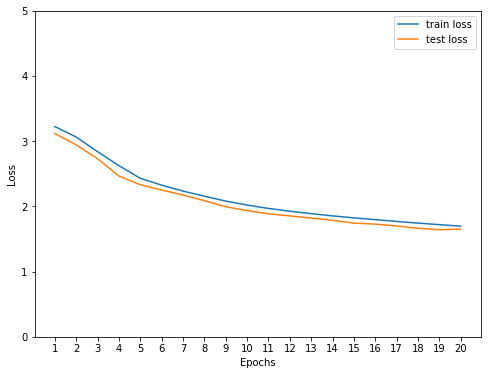

In [19]:
fig,ax = plt.subplots(figsize=(8,6))
epochs = range(1, 1+len(stats))
train_loss, test_loss, test_accuracy = zip(*stats)

ax.plot(epochs, train_loss, label = "train loss")
ax.plot(epochs, test_loss, label = "test loss")
ax.set_xticks(epochs)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_ylim([0,5])
# ax.set_title("Train and test losses");
ax.legend(loc="upper right");